In [35]:
import cantera as ct
import numpy as np
import csv

# %config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
import matplotlib.pylab as plt

print('running cantera version: ' + ct.__version__)

running cantera version: 3.0.0


In [36]:
gas = ct.Solution("data/ss_mech.yaml")

C:\Users\tahze\AppData\Local\Temp\ipykernel_27908\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in cp/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  4.1640474673509615
	Value computed using high-temperature polynomial: 2.7303344722452962

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_27908\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in h/RT detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  -1677.869344773688
	Value computed using high-temperature polynomial: -1656.701813502562

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_27908\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in s/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  11.253302479772398
	Value computed using high-temperature polynomial: 14.675098919376222

In [37]:
reactor_T = 2050.0 # temp of AP premixed flame
reactor_P = 101325 # Pa

mass_percent_AP = 70

n_NH3 = mass_percent_AP/117.49  # deflagration of AP (not gas phase)
n_HCLO4 = n_NH3
n_C2H4 = (100-mass_percent_AP)/28.00 # almost all HTPB decomposes into C2H4 at high temp of reactor

phi = (2/0.523)/((2*n_NH3)/n_C2H4)

gas.set_equivalence_ratio(phi=phi, fuel="C2H4", oxidizer={"NH3": 1.0, "HCLO4": 1.0})

gas.TP = reactor_T, reactor_P

In [38]:
initial_pressure = 0.1  # MPa
final_pressure = 10.0  # MPa
pressure_step = 0.01  # MPa

In [48]:
def calculate_burn_rate(gas, pressure, temp):
    reactor = ct.IdealGasReactor(gas)
    gas.TP = temp, pressure * 1.0e6  # Convert pressure to Pa

    sim = ct.ReactorNet([reactor])

    # Track the progress of the reaction
    progress = []

    while sim.time < 0.1:  # Adjust the simulation time as needed
        sim.step()
        progress.append(reactor.Y[gas.species_index('H2O')])

    # Calculate the burn rate (cm/s) based on progress and time
    time = np.linspace(0, sim.time, len(progress))
    burn_rate = np.gradient(progress, time)  # Derivative of progress with respect to time

    return time, burn_rate[0]  # Return the initial burn rate

In [49]:
pressures = np.arange(initial_pressure, final_pressure, pressure_step)
burn_rates = []

for pressure in pressures:
    _, burn_rate = calculate_burn_rate(gas, pressure, reactor_T)
    burn_rates.append(burn_rate)

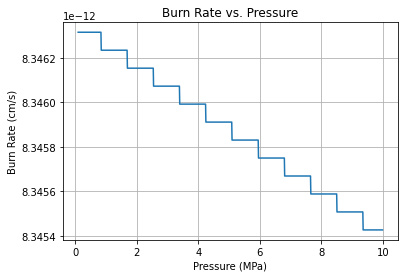

In [50]:
# Plot the burn rate vs. pressure
plt.plot(pressures, burn_rates)
plt.xlabel('Pressure (MPa)')
plt.ylabel('Burn Rate (cm/s)')
plt.title('Burn Rate vs. Pressure')
plt.grid()
plt.show()